<a href="https://colab.research.google.com/github/kyunghyuncho/ammi-2019-nlp/blob/master/01-day-LM/ngram_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling

## Goal: compute a probabilty distribution over all possible sentences:


## $$p(W) = p(w_1, w_2, ..., w_T)$$

## This unsupervised learning problem can be framed as a sequence of supervised learning problems:

## $$p(W) = p(w_1) * p(w_2|w_1) * ... * p(w_T|w_1, ..., w_{T-1})$$

## If we have N sentences, each of them with T words / tokens, then we want to max:

## $$log p(W) = \sum_{n = 1}^N \sum_{i=1}^{T} log p(w_i | w_{<i})$$




# N-gram language model

## Goal: estimate the n-gram probabilities using counts of sequences of n consecutive words

## Given a sequence of words $w$, we want to compute

##  $$P(w_i|w_{i−1}, w_{i−2}, …, w_{i−n+1})$$

## Where $w_i$ is the i-th word of the sequence.

## $$P(w_i|w_{i−n+1}, ..., w_{i−2}, w_{i−1}) = \frac{p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w_i)}{\sum_{w \in V} p(w_{i−n+1}, ..., w_{i−2}, w_{i−1}, w)}$$

## Key Idea: We can estimate the probabilities using counts of n-grams in our dataset 


# Let's see this in Practice

In [17]:
# TODOs
#: implement the neural LM with concat instead of summation -- so that you have a fixed input etc.
# make a separate
# create some slides with pictures maybe explaining the model visualizations -- line by line
# get google cloud working
# make it work on gpu
# show them kenlm and how to use to do different stuff with it
# use the same sentences to generation and testing etc.
# explain perplexity
# ngram, ff, rnn, rnn+attention
# do sentence generation
# do long sentences
# compare different n-grams -- 2,3,more

### Install if needed

TODO: should we install as needed and import as needed or all at once?

In [18]:
# # run if you dont have it installed
# !pip install more_itertools
# !pip install spacy# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager\
# !python -m spacy download en_core_web_sm
# !

### Imports

In [101]:
import sys
sys.path.insert(0, "/home/roberta/ParlAI")
print(sys.path)


['/home/roberta/ParlAI', '/home/roberta/ParlAI', '/home/roberta/ParlAI', '/home/roberta/ammi-2019-nlp/01-day-LM', '/home/roberta/ammi-2019-nlp/01-day-LM', '/home/roberta/playground', '/home/roberta/general-value-function', '/home/roberta/general-value-function/baselines', '/home/roberta/general-value-function/mazebase', '/home/roberta/general-value-function/mazebase/mazebase', '/home/roberta/miniconda3/envs/ammi/lib/python37.zip', '/home/roberta/miniconda3/envs/ammi/lib/python3.7', '/home/roberta/miniconda3/envs/ammi/lib/python3.7/lib-dynload', '', '/home/roberta/miniconda3/envs/ammi/lib/python3.7/site-packages', '/home/roberta/miniconda3/envs/ammi/lib/python3.7/site-packages/IPython/extensions', '/home/roberta/.ipython']


In [102]:
import numpy as np
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy
import itertools
from operator import itemgetter 
from glob import glob
from tqdm import tqdm_notebook, tqdm
_tqdm = tqdm_notebook
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import string
import re
import more_itertools as mit  # not built-in package
import torch
import torchtext
import torchtext.data as data
from torchtext import vocab
from collections import Counter
import re
from torchtext.data import TabularDataset 
import pandas
import altair
from parlai.core.torch_agent import TorchAgent, Output


In [2]:
torch.manual_seed(1)


In [3]:
print(torch.__version__)

1.0.1.post2


## Data Processing

In [4]:
import torch
import torchtext
import torchtext.data as data
from torchtext import vocab
from collections import Counter
import re
from torchtext.data import TabularDataset 

class AmazonReviewsDataset(TabularDataset):
    
    urls = [
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Movies_and_TV_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_CDs_and_Vinyl_5.json.gz',
           'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Sports_and_Outdoors_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Health_and_Personal_Care_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Tools_and_Home_Improvement_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Beauty_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Apps_for_Android_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Office_Products_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Pet_Supplies_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Automotive_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Grocery_and_Gourmet_Food_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Patio_Lawn_and_Garden_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Baby_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz',
#            'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz',
#             'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz',
        ]
    name='amazonreviews'
    dirname='processed'

In [5]:
# # download_done = AmazonReviewsDataset.download(root='data/', check=True)

# # if above does not work do this in stead in cd ammi-2019-nlp/data
# !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
# !gunzip reviews_Clothing_Shoes_and_Jewelry_5.json.gz


In [6]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

def tokenize(s):
    return RETOK.findall(s)

text_field = data.Field(sequential=True, tokenize=tokenize, include_lengths=True, use_vocab=True, lower=True, batch_first=True)

In [7]:
dataset = AmazonReviewsDataset(path='/home/roberta/ammi-2019-nlp/data/reviews_Clothing_Shoes_and_Jewelry_5.json', format='json', fields={'reviewText': ('reviewText', text_field), 'summary': ('summary', text_field)})


In [8]:
# lets check it
# lets use fstrings btw
print(f'Number of samples : {len(dataset.examples)}')

for ex in dataset.examples:
    print(f'Review: \n {ex.reviewText} \n\n Summary: \n {ex.summary}')
    break

Number of samples : 278677
Review: 
 ['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', '.', 'it', 'doesn', "'", 't', 'look', 'cheap', 'at', 'all', '.', 'i', "'", 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', "'", 't', 'made', 'poorly', '.', 'a', '+', '+'] 

 Summary: 
 ['great', 'tutu', '-', 'not', 'cheaply', 'made']


In [9]:
# convert the dataset to a list of strings
# each string represents a review
all_reviews = []
for ex in dataset.examples:
    all_reviews.append(ex.reviewText)
len(all_reviews)

278677

In [10]:
all_reviews[0]

['this',
 'is',
 'a',
 'great',
 'tutu',
 'and',
 'at',
 'a',
 'really',
 'great',
 'price',
 '.',
 'it',
 'doesn',
 "'",
 't',
 'look',
 'cheap',
 'at',
 'all',
 '.',
 'i',
 "'",
 'm',
 'so',
 'glad',
 'i',
 'looked',
 'on',
 'amazon',
 'and',
 'found',
 'such',
 'an',
 'affordable',
 'tutu',
 'that',
 'isn',
 "'",
 't',
 'made',
 'poorly',
 '.',
 'a',
 '+',
 '+']

In [30]:

_tqdm = tqdm_notebook  # prolly you need jupyter widget for this, change for tqdm for simple tqdm

NUM_SENTENCES = len(all_reviews)
NUM_SENTENCES_TRAIN = int(0.8*NUM_SENTENCES)
NUM_SENTENCES_TEST = int(0.1*NUM_SENTENCES)
NUM_SENTENCES_VALID = NUM_SENTENCES - NUM_SENTENCES_TRAIN - NUM_SENTENCES_TEST

train_reviews = all_reviews[:NUM_SENTENCES_TRAIN]
test_reviews = all_reviews[NUM_SENTENCES_TRAIN:NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST]
valid_reviews = all_reviews[NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST:NUM_SENTENCES_TRAIN+NUM_SENTENCES_TEST+NUM_SENTENCES_VALID]


In [31]:
type(train_reviews), len(train_reviews), type(train_reviews[0]), type(train_reviews[0][0]), train_reviews[0][11], train_reviews[0]#, test_reviews[0], valid_reviews[0]


(list,
 222941,
 list,
 str,
 '.',
 ['this',
  'is',
  'a',
  'great',
  'tutu',
  'and',
  'at',
  'a',
  'really',
  'great',
  'price',
  '.',
  'it',
  'doesn',
  "'",
  't',
  'look',
  'cheap',
  'at',
  'all',
  '.',
  'i',
  "'",
  'm',
  'so',
  'glad',
  'i',
  'looked',
  'on',
  'amazon',
  'and',
  'found',
  'such',
  'an',
  'affordable',
  'tutu',
  'that',
  'isn',
  "'",
  't',
  'made',
  'poorly',
  '.',
  'a',
  '+',
  '+'])

In [32]:
# Create .txt files with the reviews

with open('../data/amazon_reviews_clothing_train.txt', 'w') as f:
    for review in train_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")
        
with open('../data/amazon_reviews_clothing_test.txt', 'w') as f:
    for review in test_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")
        
with open('../data/amazon_reviews_clothing_valid.txt', 'w') as f:
    for review in valid_reviews:
        for token in review:
            f.write("%s " % token) 
        f.write("\n")

### Load Data from .txt Files

In [140]:
# Read data from .txt files and create lists of reviews

train_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_train.txt', 'r') as f:
    train_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     train_data.append(review.split())
    
test_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_test.txt', 'r') as f:
    test_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     test_data.append(review.split())
    
valid_data = []
# create a list of all the reviews 
with open('../data/amazon_reviews_clothing_valid.txt', 'r') as f:
    valid_data = [review for review in f.read().split('\n') if review]
# split each review into the tokens that compose it
# for review in reviews:
#     valid_data.append(review.split())


In [141]:

type(train_data), len(train_data), \
type(train_data[0]), len(train_data[0]), \
type(train_data[0][0]), len(train_data[0][0])




(list, 222919, str, 184, str, 1)

In [142]:
train_data[0], train_data[0][0]


("this is a great tutu and at a really great price . it doesn ' t look cheap at all . i ' m so glad i looked on amazon and found such an affordable tutu that isn ' t made poorly . a + + ",
 't')

### Process the Data

In [143]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')               
punctuations = string.punctuation
# punctuations = '"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~' 
TAG_RE = re.compile(r'<[^>]+>') # get rid off HTML tags from the data

def remove_tags(text):
    return TAG_RE.sub('', text)

def lower_case(parsed):
    return [token.text.lower() for token in parsed] #and (token.is_stop is False)]

def remove_punc(parsed):
    return [token.text for token in parsed if (token.text not in punctuations)]

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if (token.text not in punctuations)] #and (token.is_stop is False)]

def tokenize_dataset(dataset):
   # tokenize each sentence -- each tokenized sentence will be an element in token_dataset
    token_dataset = []
    # tokenize all words -- each token will be an item in all_tokens (in the order given by the list of sentences)
    all_tokens = []     # all the tokens -- 

    for sample in _tqdm(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
#         tokens = lower_case_remove_punc(sample)
        tokens = lower_case(sample)       # make words lower case
#         tokens = remove_punct(tokens)     # remove punctuation
        token_dataset.append(tokens)    
        all_tokens += tokens
        
    return token_dataset, all_tokens

In [144]:
punctuations, punctuations[0], \
type(punctuations), len(punctuations), type(punctuations[0]), 

('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', '!', str, 32, str)

In [145]:
TAG_RE

re.compile(r'<[^>]+>', re.UNICODE)

In [146]:
# TODO: for now only work with small subset of the data -- switch to all data later
train_data = train_data[:80]
test_data = test_data[:10]
valid_data = valid_data[:10]

In [147]:
type(train_data), type(train_data[0]), type(train_data[0][0])

(list, str, str)

In [148]:
# Tokenize the Datasets
# TODO: this takes a really long time !! why?
train_data_tokenized, all_tokens_train = tokenize_dataset(train_data)
test_data_tokenized, all_tokens_test = tokenize_dataset(test_data)
valid_data_tokenized, all_tokens_valid = tokenize_dataset(valid_data)


Let's look at the tokenized data!

In [149]:
# Number of All Tokens
len(all_tokens_train), all_tokens_train[0], \
len(train_data_tokenized), train_data_tokenized[0]

(14771,
 'this',
 80,
 ['this',
  'is',
  'a',
  'great',
  'tutu',
  'and',
  'at',
  'a',
  'really',
  'great',
  'price',
  '.',
  'it',
  'doesn',
  "'",
  't',
  'look',
  'cheap',
  'at',
  'all',
  '.',
  'i',
  "'",
  'm',
  'so',
  'glad',
  'i',
  'looked',
  'on',
  'amazon',
  'and',
  'found',
  'such',
  'an',
  'affordable',
  'tutu',
  'that',
  'isn',
  "'",
  't',
  'made',
  'poorly',
  '.',
  'a',
  '+',
  '+'])

#### Build the Vocabulary 


In [150]:
# Build a vocabulary using all the tokens found in train data (90% of most common ones)
voc = list(set(all_tokens_train))
print('Word vocabulary size: {} words'.format(len(voc)))        


Word vocabulary size: 2091 words


### CORPUS ANALYSIS (Train + Valid Data)

#### Number of Tokens in the Corpus Data


In [151]:
print("Number of All Tokens ", len(all_tokens_train))

Number of All Tokens  14771


In [152]:
print("Number of All UNIQUE Tokens ", len(voc))

Number of All UNIQUE Tokens  2091


#### Number of Sentences in the Train Data


In [153]:
print("Number of Sentences ", len(train_data_tokenized))

Number of Sentences  80


#### Count how often each sentence length occurs. Visualize this! 

#### Average sentence length

## N-grams

In [154]:
n = 3 # trigrams

#### Change n to see how the results change
#### unigrams: n = 1; bigrams: n = 2; trigrams: n = 3;


#### Generate a list of words and their corresponding frequencies. Which are the 10 most frequent words?



### Function for padding the sentences with special markers sentence beginning and end, i.e. $<bos>$ and $<eos>$

In [155]:
def pad_sentences(input_list, n):
    result_list = []
    for l in input_list:
        padded = ["<bos>" for i in range((n - 1))] + l +["<eos>" for i in range((n - 1))]
        result_list.append(padded)
    return result_list

In [156]:
train_padded = pad_sentences(train_data_tokenized, n)
valid_padded = pad_sentences(valid_data_tokenized, n)
test_padded = pad_sentences(test_data_tokenized, n)

In [157]:
# train_padded[:2]

### Function for finding all N-grams

In [158]:
def find_ngrams(input_list, n):
    result_list = []
    for l in input_list:
        result_list.append(list(zip(*[l[i:] for i in range(n)])))
    return result_list

#### Convert the dataset to its corresponding n-gram version

In [159]:
# train_ngram[:2]

### Function for Getting N-gram counts for already tokenized data

In [160]:
def ngram_counts(data, n, frac_vocab=0.9):    
    all_train_tokens = list(mit.flatten(data))
    counted_tokens = Counter(all_train_tokens)
    max_vocab_size = int(frac_vocab * len(counted_tokens))

    vocab, count = zip(*counted_tokens.most_common(max_vocab_size))
    
    return vocab, count

In [162]:
train_ngram = find_ngrams(train_padded, n)
vocab_trigram, count_trigram = ngram_counts(train_ngram, n)
vocab_trigram, count_trigram = ngram_counts(train_ngram, n)
vocab_ngram, count_ngram = ngram_counts(train_ngram, n)
# train_ngram

In [42]:
# vocab_ngram[:3], count_ngram[:3]

In [43]:
PAD_IDX = 0
UNK_IDX = 1 
BOS_IDX = 2
EOS_IDX = 3

### Function for Getting N-gram Dict

In [44]:
def ngram_dict(vocab):
    PAD_IDX = 0
    UNK_IDX = 1 
    BOS_IDX = 2
    EOS_IDX = 3
    
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(4, 4+len(vocab)))) 
    id2token = ['<pad>', '<unk>', '<bos>', '<eos>'] + id2token

    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    token2id['<bos>'] = BOS_IDX 
    token2id['<eos>'] = EOS_IDX

    return id2token, token2id

In [45]:
id2token_ngram, token2id_ngram = ngram_dict(vocab_ngram)

In [46]:
id2token_ngram[:10], \
# token2id_ngram['<unk>'], token2id_ngram['<eos>'], token2id_ngram[('rosetta', 'stone')]

(['<pad>',
  '<unk>',
  '<bos>',
  '<eos>',
  ('.', '<eos>', '<eos>'),
  ('it', "'", 's'),
  ('.', '.', '.'),
  ('i', "'", 'm'),
  ('<bos>', '<bos>', 'i'),
  ('don', "'", 't')],)

In [47]:
random_token_id = random.randint(0, len(id2token_ngram) - 1)
random_token = id2token_ngram[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token_ngram[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id_ngram[random_token]))

Token id 10460 ; token ("'", 's', 'used')
Token ("'", 's', 'used'); token id 10460


In [48]:
def _text2id(doc, token2id):
    return [token2id[t] if t in token2id else UNK_IDX for t in doc]

def _id2text(vec, id2token):
    return [id2token[i] for i in vec]

In [226]:
def create_data_id(data, token2id):
    data_id = []
    for d in data:
        data_id.append(_text2id(d, token2id))
    return data_id

def create_data_id_merged(data, token2id, n):
    data_id_merged = []
    for d in data:
        for i in range(len(d) - n):
            data_id_merged.append((d[i:i+n], d[i+n]))
    return data_id_merged

In [227]:
n = 1
train_padded_uni = pad_sentences(train_data_tokenized, n)
train_unigram = find_ngrams(train_padded_uni, n)
vocab_unigram, count_unigram = ngram_counts(train_unigram, n)
id2token_unigram, token2id_unigram = ngram_dict(vocab_unigram)


In [228]:
n = 3
data_id = create_data_id(train_unigram, token2id_unigram)
data_id_merged = create_data_id_merged(data_id, token2id_unigram, n)

train_data_id = data_id
train_data_id_merged = data_id_merged

([16, 14, 10], 65)

In [219]:
valid_ngram = find_ngrams(valid_padded, n)
valid_data_id = create_data_id(valid_ngram, token2id_ngram)
valid_data_id_merged = create_data_id_merged(valid_data_id, token2id_ngram)


TypeError: create_data_id_merged() missing 1 required positional argument: 'n'

In [52]:
# type(data_id), data_id[0]

In [53]:
# type(data_id_merged), data_id_merged[0]

In [54]:
# Function that combines all the aboce and goes from tokenized data to the ngram dataset
def create_id_dataset(data, n):
    padded_data = pad_sentences(data, n)
    ngram_data = find_ngrams(padded_data, n)
    
    vocab, count = ngram_counts(ngram_data, n)    
    id2token, token2id = ngram_dict(vocab)
    
    data_id = create_data_id(ngram_data, token2id)
    data_id_merged = create_data_id_merged(data_id, token2id)
    
    return data_id, data_id_merged

In [55]:
all_data_id, all_data_id_merged = create_id_dataset(train_data_tokenized, n)

In [56]:
# all_data_id[0], all_data_id_merged[0]


### Function for computing the probability of an n-gram

In [57]:
vocab_ngram[:10], count_ngram[:10]

((('.', '<eos>', '<eos>'),
  ('it', "'", 's'),
  ('.', '.', '.'),
  ('i', "'", 'm'),
  ('<bos>', '<bos>', 'i'),
  ('don', "'", 't'),
  ('!', '<eos>', '<eos>'),
  ('i', "'", 've'),
  ('.', 'i', "'"),
  ('you', "'", 're')),
 (59, 40, 33, 26, 23, 23, 14, 14, 13, 13))

In [58]:
def get_ngram_count(ngram, vocab, count):
    if ngram in vocab:
        ngram_idx = vocab.index(ngram)
        return count[ngram_idx] 
    else:
        return 0


In [59]:
c = get_ngram_count(('.', 'i'), vocab_ngram, count_ngram)
c

# c = get_ngram_count(('baby', 'panda'), vocab_ngram, count_ngram)
# c

0

In [60]:
c = get_ngram_count(('it', "'", 's'), vocab_ngram, count_ngram)
c


# c = get_ngram_count(('baby', 'panda', 'sweet'), vocab_ngram, count_ngram)
# c

40

### Function for computing the probability of a sentence

In [61]:
def get_ngram_prob(ngram, vocab, count):
    c = get_ngram_count(ngram, vocab, count)
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
#             print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

In [62]:
p = get_ngram_prob(('rosetta', 'stone'), vocab_ngram, count_ngram)
p, 69/(69+2+2+1+1+1+1+1)

# p = get_ngram_prob(('i', 'am'), vocab_ngram, count_ngram)
# p

# p = get_ngram_prob(('it', "'", 's'), vocab_ngram, count_ngram)
# p

# p = get_ngram_prob(('i', "like", 'it'), vocab_ngram, count_ngram)
# p, 1/(2+1+1+1+1)

(0, 0.8846153846153846)

In [63]:
def get_prob_sentence(sentence, vocab, count):
    padded_sentence = pad_sentences(sentence, n)  # needs a list
#     print(padded_sentence)
    ngram_sentence = find_ngrams(padded_sentence, n)[0] # only one element in list
#     print(ngram_sentence)
    prob = 1
    for ngram in ngram_sentence:
        prob_ngram = get_ngram_prob(ngram, vocab, count)
#         print(ngram, prob_ngram)
        prob *= prob_ngram
    return prob

In [64]:
sentence = [train_data_tokenized[0]]
# sentence = [['this', 'is', 'a', 'great', 'tutu']]
print(sentence)
ps = get_prob_sentence(sentence, vocab_ngram, count_ngram)
ps

[['this', 'is', 'a', 'great', 'tutu', 'and', 'at', 'a', 'really', 'great', 'price', '.', 'it', 'doesn', "'", 't', 'look', 'cheap', 'at', 'all', '.', 'i', "'", 'm', 'so', 'glad', 'i', 'looked', 'on', 'amazon', 'and', 'found', 'such', 'an', 'affordable', 'tutu', 'that', 'isn', "'", 't', 'made', 'poorly', '.', 'a', '+', '+']]


4.0055998183675866e-17

In [65]:
def get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=False):
    pd = [0 for v in voc]
    for idx, token in enumerate(voc):
#         print("token: ", token)
#         print("prev ngram: ", prev_tokens)
#         print("both: ", tuple(list(prev_tokens) + [token]))
#         print("")
        token_ngram = tuple(list(prev_tokens) + [token])
        pd[idx] = get_ngram_prob(token_ngram, vocab_ngram, count_ngram)
#         if pd[idx] > 0 and print_nonzero_probs:
#             print(token_ngram, " ", pd[idx])
    return pd

In [66]:
# prob distr for the word following prev_tokens (i.e. tutu) 
# over all the words in the vocabulary 

# prev_tokens = train_data_tokenized[0][4] #[0]
prev_tokens = vocab_ngram[3][1:] #[0]   # need frmo 1 on so that this is a correct prev token
print(prev_tokens)
pd = get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=True)
sum(pd)#, pd

("'", 'm')
("'", 'm', 'calling')   0.04
("'", 'm', 'given')   0.04
("'", 'm', 'very')   0.04
("'", 'm', 'not')   0.32
("'", 'm', 'most')   0.04
("'", 'm', 'more')   0.04
("'", 'm', 'finding')   0.04
("'", 'm', 'so')   0.08
("'", 'm', 'fluent')   0.04
("'", 'm', 'one')   0.04
("'", 'm', 'enjoying')   0.04
("'", 'm', 'sure')   0.08
("'", 'm', 'happy')   0.04
("'", 'm', 'a')   0.04
("'", 'm', 'enrolled')   0.04
("'", 'm', 'hearing')   0.04


1.0000000000000002

In [67]:
def sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=False):
    pd = get_prob_distr_ngram(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=print_nonzero_probs)
    idx_next_token = np.random.choice(len(voc), 1, p=pd)[0]
    return voc[idx_next_token]
    

In [68]:
print(prev_tokens)
next_token = sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc, print_nonzero_probs=True)
next_token

("'", 'm')
("'", 'm', 'calling')   0.04
("'", 'm', 'given')   0.04
("'", 'm', 'very')   0.04
("'", 'm', 'not')   0.32
("'", 'm', 'most')   0.04
("'", 'm', 'more')   0.04
("'", 'm', 'finding')   0.04
("'", 'm', 'so')   0.08
("'", 'm', 'fluent')   0.04
("'", 'm', 'one')   0.04
("'", 'm', 'enjoying')   0.04
("'", 'm', 'sure')   0.08
("'", 'm', 'happy')   0.04
("'", 'm', 'a')   0.04
("'", 'm', 'enrolled')   0.04
("'", 'm', 'hearing')   0.04


'enjoying'

In [69]:
def generate_sentence(num_tokens, vocab_ngram, count_ngram, voc, n):
    sentence = []
    prev_tokens = tuple(['<bos>'] * (n - 1))
#     print(prev_tokens)
    for i in range(num_tokens):
        next_token = sample_from_pd(prev_tokens, vocab_ngram, count_ngram, voc)
#         print(i, next_token)
#         print(i, prev_tokens[1:])
        prev_tokens = tuple(list(prev_tokens[1:]) + [next_token])
#         print(i, prev_tokens)
        sentence.append(next_token)
        print(' '.join(sentence))
    return ' '.join(sentence)

In [70]:
num_tokens = 5
generated_sentence = generate_sentence(num_tokens, vocab_ngram, count_ngram, voc, n)
generated_sentence

# TODO: make this owkr for general ngram -- double check that it works

i
i got
i got this
i got this costume
i got this costume (


'i got this costume ('

## Add-One Smoothing

In [71]:
def get_ngram_prob_add_one_smoothing(ngram, vocab, count):
    c = get_ngram_count(ngram, vocab, count) + 1
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
            print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    all_counts += len(voc)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

In [72]:
# TODO: show examples
p = get_ngram_prob(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram)
p


0

In [73]:
p = get_ngram_prob_add_one_smoothing(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram)
p


0.00047824007651841227

## Additive Smoothing

In [74]:
def get_ngram_prob_addditive_smoothing(ngram, vocab, count, delta=0.5):
    c = get_ngram_count(ngram, vocab, count) + delta*1
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
#             print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    all_counts += delta*len(voc)
    if all_counts > 0:
        return c / all_counts
    else:
        return 0

In [75]:
p = get_ngram_prob_addditive_smoothing(('am', 'rosetta', 'stone'), vocab_ngram, count_ngram, delta=0.1)
p

0.0004782400765184122

### Linear Interpolation Smoothing

In [76]:
def get_ngram_prob_interpolation_smoothing(ngram, vocab, count, prev_vocab, prev_count, alpha=0.5):
    c = get_ngram_count(ngram, vocab, count)
    all_counts = 0
    for t in vocab:
        if t[:-1] == ngram[:-1]:
#             print(t, get_ngram_count(t, vocab, count))
            all_counts += get_ngram_count(t, vocab, count)
    if all_counts > 0:
        prob_ngram = c / all_counts
    else:
        prob_ngram = 0
    
    prev_ngram = tuple(list(ngram[1:]))
    prev_c = get_ngram_count(prev_ngram, prev_vocab, prev_count)
#     print(prev_c)
    prev_all_counts = 0
    for prev_t in prev_vocab:
        if prev_t[:-1] == prev_ngram[:-1]:
#             print(prev_t, get_ngram_count(prev_t, prev_vocab, prev_count))
            prev_all_counts += get_ngram_count(prev_t, prev_vocab, prev_count)
    if prev_all_counts > 0:
        prob_prev_ngram = prev_c / prev_all_counts
    else:
        0
    return alpha*(prob_ngram) + (1-alpha)*prob_prev_ngram

In [77]:
train_padded = pad_sentences(train_data_tokenized, 3)
train_trigram = find_ngrams(train_padded, 3)
vocab_trigram, count_trigram = ngram_counts(train_trigram, 3)


train_padded = pad_sentences(train_data_tokenized, 2)
train_bigram = find_ngrams(train_padded, 2)
vocab_bigram, count_bigram = ngram_counts(train_bigram, 2)

train_padded = pad_sentences(train_data_tokenized, 1)
train_unigram = find_ngrams(train_padded, 1)
vocab_unigram, count_unigram = ngram_counts(train_unigram, 1)


### Smoothing: Linear Interpolation with Absolute Discounting

In [78]:
def get_unigram_count(r):
    return np.sum([1 for i in range(len(vocab_unigram)) if count_unigram[i] == r])

def get_bigram_count(r):
    return np.sum([1 for i in range(len(vocab_bigram)) if count_bigram[i] == r])

def get_biunigram_count(r, token):
    cc = 0
    for other_token in vocab_unigram:
        bigram = tuple([token] + [other_token])
        if bigram in vocab_bigram:
            bigram_idx = vocab_bigram.index(bigram) 
            if count_bigram[bigram_idx] == r:
                cc += 1
                
#     for bigram in vocab_bigram:
#         print(token, bigram[0])
#         if token == bigram[0]:
#             bigram_idx = vocab_bigram.index(bigram) 
#             if count_bigram[bigram_idx] == r:
#                 cc += 1
    return cc

def get_b_bi():
    bbi = get_bigram_count(1) / (get_bigram_count(1) + 2 * get_bigram_count(2))
    return bbi
    
def get_b_uni():
    buni = get_unigram_count(1) / (get_unigram_count(1) + 2 * get_unigram_count(2))
    return buni

def get_p_uni(w):
    if w in vocab_unigram:
        w_idx = vocab_unigram.index(w)
        N_w = count_unigram[w_idx]
    else:
        N_w = 0
        
    b_uni = get_b_uni()
    
    W = len(voc)
    N_0 = get_unigram_count(0)
    
    
    N = len(all_tokens_train) # TODO: double check the meaning of N 
    
    p_uni = max((N_w - b_uni / N), 0) + b_uni * (W - N_0) / N * 1 / W
    
    return p_uni

def get_p_bi(w, v):   # w given v
    if tuple([v] + [w]) in vocab_bigram:
        vw_idx = vocab_bigram.index(tuple([v] + [w]))
        N_vw = count_bigram[vw_idx]
    else:
        N_vw = 0
        
    if tuple([v]) in vocab_unigram:
        v_idx = vocab_unigram.index(tuple([v]))
        N_v = count_unigram[v_idx]
    else:
        N_v = 0  
        
    b_bi = get_b_bi()
    b_uni = get_b_uni()
    
    p_uni = get_p_uni(tuple([w]))
    
    W = len(voc)
    N_0 = get_biunigram_count(0, v)
    
    
    p_bi =  max((N_vw - b_bi) / N_v,  0) + \
         b_bi * (W - N_0) / N_v * p_uni
    
    return p_bi
        

In [79]:
x = 'stone'
y = 'rosetta'

z = get_p_bi(y, x)
z

1744.7693023255813

## Bigram Probabilities

### $$p_{bi}(w|v) = max ({ \frac{N(v, w) - b_{bi}}{N(v)}, 0)  + b_{bi} \frac{V - N_0(v, \cdot)}{N(v)} p_{uni}(w) \large}$$

### $$p_{uni}(w) = max ({ \frac{N(w) - b_{uni}}{N}, 0)  + b_{uni} \frac{V - N_0(\cdot)}{N} \frac{1}{V}}$$

### $$b_{bi} = \frac{N_1(\cdot, \cdot)}{N_1(\cdot, \cdot) + 2*N_2(\cdot, \cdot)}$$

### $$b_{uni} = \frac{N_1(\cdot)}{N_1(\cdot) + 2*N_2(\cdot)}$$


### $$N_r(\cdot) = \sum_{w: N(w) = r} 1$$

### $$N_r(\cdot, \cdot) = \sum_{v, w: N(v, w) = r} 1$$

### $$N_r(v, \cdot) = \sum_{w: N(v, w) = r} 1$$

### V is the number of words in the vocabulary

### $N_r(\cdot, \cdot)$ and $N_r(\cdot)$  are the count-counts for bigrams and unigrams respectively $


In [80]:
# TODO: Let's compute the bigram frequencies / probabilities



### Let's check that the probabilities sum up to one
### $$\sum_w p_{bi}(w|v) = \sum_w p_{uni}(w) = 1$$



In [81]:
# TODO: compute the sums

# show rank for each word in a sentence
# explain perplexity 

### Log-Likelihood
### $LL = \sum_{k=1}^{K} \sum_{n=1}^{N_k + 1} log p_{bi}(w_{k,n} | w_{k,n-1})$

### Perplexity

### $PP = exp(-\frac{LL}{\sum_k(N_k + 1)})$

In [ ]:
def get_perplexity(test_sentences, vocab_ngram, count_ngram):
    ll = 0
    num_tokens = 0
    for s in (test_sentences):
        ll += get_prob_sentence([s], vocab_ngram, count_ngram)
        num_tokens += len(s) + 1

    ppl = np.exp(-ll/num_tokens)
    return ppl

In [ ]:
ppl_test = get_perplexity(test_data_tokenized, vocab_ngram, count_ngram)
ppl_valid = get_perplexity(valid_data_tokenized, vocab_ngram, count_ngram)
ppl_train = get_perplexity(train_data_tokenized, vocab_ngram, count_ngram)


In [ ]:
ppl_test, ppl_valid, ppl_train
# TODO check whether this makes sense -- maybe it seems too good?

#### Let's look at some examples and see if they make sense

#### Generate a complete list of trigrams occurring in the corpus. Which are the 10 most frequent trigrams?



#### Determine count statistics on the trigram frequencies, i.e. compute so-called count-counts (how many trigrams occur once, twice, : : :). Plot their distribution.

#### Generate a list of trigrams in the corpus using only the words in the vocabulary. 

#### Generate count statistics of the trigram frequencies for this modified corpus as well. What do you notice in comparison to the previous exercise?

#### Determine the out-of-vocabulary (OOV) rate, i.e. the percentage of running words in the corpus which are not covered by the vocabulary.

### Functions for Converting from Token to ID and back

In Part 1 you generated a trigram frequency list for a given vocabulary.
Determine the list of bigram frequencies from it by summing over the first word position:
N(v;w) = N(; v;w) =
X
u
N(u; v;w)
Analogously, recompute the frequencies of unigrams.
Now, extract bigrams/unigrams directly from the corpus using your implementation from part 1
and compare it to the recomputed versions. What do you notice? How could you x this problem
without changing the recomputation method?

#### Determine the list of bigram frequencies from it by summing over the first word position:

#### $ N(u, v, w) = \sum_u N(\cdot, v, w) $

#### Do the same for the unigrams. Do we get the same numbers as before?

## N-gram Probabilities

## $$P(w|w_{−n}, ..., w_{−2}, w_{−1}) \approx \frac{c(w_{−n}, ..., w_{−2}, w_{−1}, w)}{\sum_{w \in V} c(w_{−n}, ..., w_{−2}, w_{−1}, w)}$$


## Bigram Probabilities

## $$p(w_i | w_{i-1}) = \frac{c(w_{i-1}, w_i)}{\sum_{w_i} c(w_{i-1}, w_i)} $$


## Bigram LM
##  $$p(s) = \prod_{i = 1} ^ {N + 1} p(w_i | w_{i-1})$$

### Example
### Bigram LM: $$ p(i \; love \; this \; light) = p(i|\cdot) \; p(love|i)\;  p(this|love)\;  p(light|this) \\
\approx \frac{c(i, \cdot)}{\sum_w c(\cdot, \; w)} \; \frac{c(love, i)}{\sum_wc(i, \; w)}\;  \frac{c(this, love)}{\sum_wc(love, \;w)}\;  \frac{c(light, this)}{\sum_wc(this, \;w)}$$ 

### Trigram LM: $$ p(i \; love \; this  \;light) = p(i|\cdot, \cdot) \; p(love|\cdot, i) \; p(this|i, love)\;  p(light|love, this)$$ 



### Another Example -- where this approach usually fails

### Bigram LM: $$ p(john \; went \; to \; the \; moon) = p(john|\cdot) p(went|john) p(to|went) p(the|to) p(moon|the)$$ 

### Trigram LM: $$ pp(john \; went \; to \; the \; moon = p(john|\cdot, \cdot) p(went|\cdot, john) p(to|john, went) p(the|went, to) p(moon|to, the)$$ 



## Smoothing -- which ones to show? comparisons?

### Why do we need smoothing for n-gram language modeling?

### Sentece Probability

### Sentence Generation

# Neural Language Modeling

## Make a PyTorch Dataset out of our set of dicts

In [230]:
class AmazonDataset(Dataset):
    def __init__(self, data_list, max_inp_length=None, cuda=True):
        """
        data_list is a list of tuples: (x,y) where x is a list of ids and y is a label
        """
        self.data = data_list
        self.max_len = max_inp_length
        self.data_tensors = []
        for (i, t) in tqdm_notebook(self.data):
            if cuda:
                self.data_tensors.append((torch.LongTensor(i[:self.max_len]).cuda(), \
                                            torch.LongTensor([t]).cuda()))
            else:
                self.data_tensors.append((torch.LongTensor(i[:self.max_len]), \
                                          torch.LongTensor([t])))
                
    def __getitem__(self, key):
        (inp, tgt) = self.data_tensors[key]
        
        return inp, tgt, len(inp)

    def __len__(self):
        return len(self.data)

def pad(tensor, length, dim=0, pad=0):
    """Pad tensor to a specific length.
    :param tensor: vector to pad
    :param length: new length
    :param dim: (default 0) dimension to pad
    :returns: padded tensor if the tensor is shorter than length
    """
    if tensor.size(dim) < length:
        return torch.cat(
            [tensor, tensor.new(*tensor.size()[:dim],
                                length - tensor.size(dim),
                                *tensor.size()[dim + 1:]).fill_(pad)],
            dim=dim)
    else:
        return tensor
    
def batchify(batch):
    maxlen = max(batch, key = itemgetter(2))[-1]
    batch_list = []
    target_list = []
    for b in batch:
        batch_list.append(pad(b[0], maxlen, dim=0, pad=PAD_IDX))
        target_list.append(b[1])
    input_batch = torch.stack(batch_list, 0)
    target_batch = torch.stack(target_list, 0)
    
    return input_batch, target_batch

In [233]:
def create_data_id(data, token2id):
    data_id = []
    for d in data:
        data_id.append(_text2id(d, token2id))
    return data_id

def create_data_id_merged(data, token2id, n):
    data_id_merged = []
    for d in data:
        for i in range(len(d) - n):
            data_id_merged.append((d[i:i+n], d[i+n]))
    return data_id_merged

n = 1
train_padded_uni = pad_sentences(train_data_tokenized, n)
train_unigram = find_ngrams(train_padded_uni, n)
train_vocab_unigram, train_count_unigram = ngram_counts(train_unigram, n)
train_id2token_unigram, train_token2id_unigram = ngram_dict(train_vocab_unigram)

n = 1
valid_padded_uni = pad_sentences(valid_data_tokenized, n)
valid_unigram = find_ngrams(valid_padded_uni, n)
valid_vocab_unigram, count_unigram = ngram_counts(valid_unigram, n)
valid_id2token_unigram, valid_token2id_unigram = ngram_dict(valid_vocab_unigram)

N = 10
train_data_id = create_data_id(train_unigram, train_token2id_unigram)
train_data_id_merged = create_data_id_merged(train_data_id, train_token2id_unigram, N)

valid_data_id = create_data_id(valid_unigram, valid_token2id_unigram)
valid_data_id_merged = create_data_id_merged(valid_data_id, valid_token2id_unigram, N)


In [234]:
train_dataset = AmazonDataset(train_data_id_merged, max_inp_length=None, cuda=True)
train_loader = DataLoader(train_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

valid_dataset = AmazonDataset(valid_data_id_merged, max_inp_length=None, cuda=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, collate_fn=batchify, shuffle=True)

In [236]:
train_dataset[0], train_dataset[0][0].shape, \
valid_dataset[0], valid_dataset[0][0].shape

((tensor([ 16,  14,  10,  65, 184,   9,  49,  10,  70,  65], device='cuda:0'),
  tensor([73], device='cuda:0'),
  10),
 torch.Size([10]),
 (tensor([33, 89, 90, 91,  4, 13, 21, 34, 50,  4], device='cuda:0'),
  tensor([4], device='cuda:0'),
  10),
 torch.Size([10]))

## Model

In [272]:
class BagOfNGrams(nn.Module):
    def init_layers(self):
        for l in self.layers:
            if getattr(l, 'weight', None) is not None:
                torch.nn.init.xavier_uniform_(l.weight)
    
    def __init__(self, vocab_size, emb_dim=300, hidden_size=256, out_size=128, reduce='sum', nlayers=2, activation='ReLU', dropout=0.1, batch_norm=False):
        super(BagOfNGrams, self).__init__()
       
        self.emb_dim = emb_dim
        self.reduce = reduce
        self.nlayers = nlayers
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.activation = getattr(nn, activation)
        
        self.embedding = nn.EmbeddingBag(num_embeddings=vocab_size, embedding_dim=emb_dim, mode=reduce)
        if batch_norm is True:
            self.batch_norm = nn.BatchNorm1d(self.emb_dim)
        self.layers = nn.ModuleList([nn.Linear(self.emb_dim, self.hidden_size)])
        self.layers.append(self.activation())
        self.layers.append(nn.Dropout(p=dropout))
        
        for i in range(self.nlayers-2):
            self.layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.layers.append(self.activation())
            self.layers.append(nn.Dropout(p=dropout)) 
        self.layers.append(nn.Linear(self.hidden_size, self.out_size))
        self.init_layers()
    
    def forward(self, x):
        postemb = self.embedding(x)
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(postemb)
        else:
            x = postemb
        for l in self.layers:
            x = l(x)
        
        return x

model = BagOfNGrams(len(train_id2token_unigram), emb_dim=300, hidden_size=256, out_size=128, activation='Tanh', nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)
model.cuda()

BagOfNGrams(
  (embedding): EmbeddingBag(1885, 300, mode=mean)
  (layers): ModuleList(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0)
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [273]:
class EncoderMLP(nn.Module):
    """Encodes the input context."""

    def __init__(self, input_size, hidden_size):
        """Initialize encoder.
        :param input_size: size of vocabulary
        :param hidden_size: size of the embedding
        """
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, input, hidden=None):
        """Return encoded state.
        :param input: (batchsize x seqlen) tensor of token indices.
        :param hidden: optional past hidden state
        """
        embedded = self.embedding(input)
        rel = F.relu(emb)
        output = self.linear(rel)
        return output


TypeError: __init__() missing 2 required positional arguments: 'input_size' and 'hidden_size'

In [268]:
class DecoderMLP(nn.Module):
    """Generates a token in response to context."""

    def __init__(self, output_size, output_size, hidden_size):
        """Initialize decoder.
        :param input_size: size of embedding
        :param output_size: size of vocabulary
        :param hidden_size: size of the linear layers
        """
        super().__init__()
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        """Return encoded state.
        :param input: batch_size x 1 tensor of token indices.
        :param hidden: past (e.g. encoder) hidden state
        """
        emb = self.embedding(input)
        rel = F.relu(emb)
        output = self.linear(rel)
        scores = self.softmax(self.out(output))
        return scores
    

In [267]:
learning_rate = 0.01
num_epochs=1000
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
for epoch in range(num_epochs):
    for i, (data, labels) in _tqdm(enumerate(train_loader)): 
        data.cuda()
        labels.cuda()
        model.cuda()
        
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
#         print(loss.item())
        optimizer.step()
        train_losses.append(loss.item())

    if epoch % 1 == 0 and epoch > 0:
        print("Epoch {}: ".format(epoch), loss.item())
#         val_acc = test_model(loader=valid_loader, model=model)
#         print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Acc: {}'.format( 
#                            epoch+1, num_epochs, i+1, len(train_loader), loss.item(), val_acc))
        


Epoch 1:  5.530584335327148



Epoch 2:  5.052976608276367



Epoch 3:  4.996617317199707



Epoch 4:  4.750067234039307



Epoch 5:  4.331514835357666



Epoch 6:  3.9569406509399414



Epoch 7:  4.277703285217285



Epoch 8:  3.7160022258758545



Epoch 9:  3.548503875732422



Epoch 10:  3.4557650089263916



Epoch 11:  3.380957841873169



Epoch 12:  3.115177869796753



Epoch 13:  2.725679874420166



Epoch 14:  3.0146541595458984



Epoch 15:  2.573493480682373



Epoch 16:  2.5614964962005615



Epoch 17:  2.7110095024108887



Epoch 18:  2.49350643157959



Epoch 19:  2.363624095916748



Epoch 20:  2.078869581222534



Epoch 21:  2.190570592880249



Epoch 22:  2.1928188800811768



Epoch 23:  2.0738918781280518



Epoch 24:  2.1345736980438232



Epoch 25:  1.7603297233581543



Epoch 26:  1.723686933517456



Epoch 27:  1.4937114715576172



Epoch 28:  1.6057074069976807



Epoch 29:  1.2701928615570068



Epoch 30:  1.3432286977767944



Epoch 31:  1.152726411819458



Epoch 32:  1.2144815921783447



Epoch 33:  1.1993292570114136



Epoch 34:  1.0755550861358643



Epoch 35:  1.0336395502090454



Epoch 36:  1.0070273876190186



Epoch 37:  0.7795937657356262



Epoch 38:  0.9847700595855713



Epoch 39:  0.6607604026794434



Epoch 40:  0.7541266083717346



Epoch 41:  0.695176899433136



Epoch 42:  0.6280102133750916



Epoch 43:  0.6792415976524353



Epoch 44:  0.6040502190589905



Epoch 45:  0.4773804545402527



Epoch 46:  0.5199899673461914



Epoch 47:  0.27066221833229065



Epoch 48:  0.5767067074775696



Epoch 49:  0.3751436471939087



Epoch 50:  0.3871006965637207



Epoch 51:  0.27109313011169434



Epoch 52:  0.23988346755504608



Epoch 53:  0.2285413146018982



Epoch 54:  0.3511154055595398



Epoch 55:  0.21829472482204437



Epoch 56:  0.16019408404827118



Epoch 57:  0.18711286783218384



Epoch 58:  0.17062047123908997



Epoch 59:  0.2963160276412964



Epoch 60:  0.11545462906360626



Epoch 61:  0.16287313401699066



Epoch 62:  0.25404733419418335



Epoch 63:  0.11819858849048615



Epoch 64:  0.16492429375648499



Epoch 65:  0.19139425456523895



Epoch 66:  0.13770179450511932



Epoch 67:  0.14081169664859772



Epoch 68:  0.17895552515983582



Epoch 69:  0.15204952657222748



Epoch 70:  0.09801215678453445



Epoch 71:  0.13828960061073303



Epoch 72:  0.14072515070438385



Epoch 73:  0.1507061868906021



Epoch 74:  0.06137596070766449



Epoch 75:  0.12414097785949707



Epoch 76:  0.2935289144515991



Epoch 77:  0.10195726901292801



Epoch 78:  0.18490737676620483



Epoch 79:  0.09603152424097061



Epoch 80:  0.045957811176776886



Epoch 81:  0.13204659521579742



Epoch 82:  0.06089964509010315



Epoch 83:  0.12379077821969986



Epoch 84:  0.1722605973482132



Epoch 85:  0.0978160873055458



Epoch 86:  0.27731409668922424



Epoch 87:  0.10288793593645096



Epoch 88:  0.19008681178092957



Epoch 89:  0.1385846883058548



Epoch 90:  0.13984271883964539



Epoch 91:  0.09596449881792068



Epoch 92:  0.18006892502307892



Epoch 93:  0.10640597343444824



Epoch 94:  0.24418090283870697



Epoch 95:  0.1729271113872528



Epoch 96:  0.12500637769699097



Epoch 97:  0.09616929292678833



Epoch 98:  0.1896301656961441



Epoch 99:  0.21014048159122467



Epoch 100:  0.07075037062168121



Epoch 101:  0.04716131091117859



Epoch 102:  0.16064023971557617



Epoch 103:  0.0656425952911377



Epoch 104:  0.28587132692337036



Epoch 105:  0.1476026028394699



Epoch 106:  0.12350878864526749



Epoch 107:  0.17382004857063293



Epoch 108:  0.1189606711268425



Epoch 109:  0.12388799339532852



Epoch 110:  0.20643992722034454



Epoch 111:  0.04945658892393112



Epoch 112:  0.28201964497566223



Epoch 113:  0.18484853208065033



Epoch 114:  0.1308029741048813



Epoch 115:  0.20164364576339722



Epoch 116:  0.14426623284816742



Epoch 117:  0.17359212040901184



Epoch 118:  0.07922860234975815



Epoch 119:  0.17603807151317596



Epoch 120:  0.1581689864397049



Epoch 121:  0.05105816572904587



Epoch 122:  0.18669138848781586



Epoch 123:  0.08591447025537491



Epoch 124:  0.19390462338924408



Epoch 125:  0.11250615119934082



Epoch 126:  0.2653697729110718



Epoch 127:  0.14904414117336273



Epoch 128:  0.21692469716072083



Epoch 129:  0.3684138357639313



Epoch 130:  0.23432616889476776



Epoch 131:  0.3769737184047699



Epoch 132:  0.3077819049358368



Epoch 133:  0.5071373581886292



Epoch 134:  0.35576117038726807



Epoch 135:  0.6441788673400879



Epoch 136:  0.49555081129074097



Epoch 137:  0.6185939908027649



Epoch 138:  0.3083677291870117



Epoch 139:  0.2057582288980484



Epoch 140:  0.1022028923034668



Epoch 141:  0.1711105853319168



Epoch 142:  0.1087096631526947



Epoch 143:  0.06293545663356781



Epoch 144:  0.16533184051513672



Epoch 145:  0.07695075869560242



Epoch 146:  0.07054059207439423



Epoch 147:  0.22009064257144928



Epoch 148:  0.020988451316952705



Epoch 149:  0.07282786816358566



Epoch 150:  0.125896155834198



Epoch 151:  0.12122225761413574



Epoch 152:  0.12889616191387177



Epoch 153:  0.12153752893209457



Epoch 154:  0.13461720943450928



Epoch 155:  0.02817356400191784



Epoch 156:  0.04896240308880806



Epoch 157:  0.04480517655611038



Epoch 158:  0.06296484917402267



Epoch 159:  0.2625603973865509



Epoch 160:  0.002772571286186576



Epoch 161:  0.1657388061285019



Epoch 162:  0.09772977977991104



Epoch 163:  0.0041860854253172874



Epoch 164:  0.10353907197713852



Epoch 165:  0.2578519582748413



Epoch 166:  0.16199497878551483



Epoch 167:  0.15165972709655762



Epoch 168:  0.17877425253391266



Epoch 169:  0.1317942887544632



Epoch 170:  0.2323365956544876



Epoch 171:  0.3652636706829071



Epoch 172:  0.050516724586486816



Epoch 173:  0.12392152845859528



Epoch 174:  0.10249603539705276



Epoch 175:  0.07789985835552216



Epoch 176:  0.034436918795108795



Epoch 177:  0.24117806553840637



Epoch 178:  0.02643417753279209



Epoch 179:  0.12490967661142349



Epoch 180:  0.24500557780265808



Epoch 181:  0.15527662634849548



Epoch 182:  0.06757205724716187



Epoch 183:  0.08195649832487106



Epoch 184:  0.1210845485329628



Epoch 185:  0.18002872169017792



Epoch 186:  0.2099340856075287



Epoch 187:  0.2074047029018402



Epoch 188:  0.3592781126499176



Epoch 189:  0.07698405534029007



Epoch 190:  0.2424527406692505



Epoch 191:  0.26945656538009644



Epoch 192:  0.06161133199930191



Epoch 193:  0.14473801851272583



Epoch 194:  0.19654813408851624



Epoch 195:  0.09532430022954941



Epoch 196:  0.026812806725502014



Epoch 197:  0.08947908133268356



Epoch 198:  0.09606923162937164



Epoch 199:  0.21274864673614502



Epoch 200:  0.07323331385850906



Epoch 201:  0.15780821442604065



Epoch 202:  0.11072729527950287



Epoch 203:  0.20563791692256927



Epoch 204:  0.21673840284347534



Epoch 205:  0.19660137593746185



Epoch 206:  0.17172983288764954



Epoch 207:  0.17294567823410034



Epoch 208:  0.20803096890449524



Epoch 209:  0.19750158488750458



Epoch 210:  0.07035444676876068



Epoch 211:  0.1972658634185791



Epoch 212:  0.24437737464904785



Epoch 213:  0.19847816228866577



Epoch 214:  0.2843068540096283



Epoch 215:  0.3459928035736084



Epoch 216:  0.09904631972312927



Epoch 217:  0.19412074983119965



Epoch 218:  0.10036563128232956



Epoch 219:  0.1965983361005783



Epoch 220:  0.021631021052598953



Epoch 221:  0.1826825737953186



Epoch 222:  0.10710782557725906



Epoch 223:  0.4263889491558075



Epoch 224:  0.22117318212985992



Epoch 225:  0.11041685193777084



Epoch 226:  0.17376066744327545



Epoch 227:  0.16178128123283386



Epoch 228:  0.24576425552368164



Epoch 229:  0.0701633095741272



Epoch 230:  0.06716258823871613



Epoch 231:  0.01973872259259224



Epoch 232:  0.19445961713790894



Epoch 233:  0.41545024514198303



Epoch 234:  0.03238087520003319



Epoch 235:  0.02433447353541851



Epoch 236:  0.15089592337608337



Epoch 237:  0.053828101605176926



Epoch 238:  0.09648195654153824



Epoch 239:  0.2136087864637375



Epoch 240:  0.05505441129207611



Epoch 241:  0.10915983468294144



Epoch 242:  0.2402816265821457



Epoch 243:  0.05598568916320801



Epoch 244:  0.0547831654548645



Epoch 245:  0.16423100233078003



Epoch 246:  0.1841808557510376



Epoch 247:  0.31198790669441223



Epoch 248:  0.12628722190856934



Epoch 249:  0.2335914820432663



Epoch 250:  0.22358469665050507



Epoch 251:  0.13239449262619019



Epoch 252:  0.19355788826942444



Epoch 253:  0.1266452670097351



Epoch 254:  0.04968683421611786



Epoch 255:  0.20109021663665771



Epoch 256:  0.15172551572322845



Epoch 257:  0.3551090657711029



Epoch 258:  0.12385264784097672



Epoch 259:  0.04391924664378166



Epoch 260:  0.03875104337930679



Epoch 261:  0.058864399790763855



Epoch 262:  0.24172469973564148



Epoch 263:  0.17849956452846527



Epoch 264:  0.07817557454109192



Epoch 265:  0.20375506579875946



Epoch 266:  0.3028198182582855



Epoch 267:  0.13741755485534668



Epoch 268:  0.12262918800115585



Epoch 269:  0.058763206005096436



Epoch 270:  0.25745946168899536



Epoch 271:  0.020534371957182884



Epoch 272:  0.14427892863750458



Epoch 273:  0.08685797452926636



Epoch 274:  0.1943879872560501



Epoch 275:  0.028352413326501846



Epoch 276:  0.09603959321975708



Epoch 277:  0.2063465714454651



Epoch 278:  0.0971757024526596



Epoch 279:  0.19866709411144257



Epoch 280:  0.18610452115535736



Epoch 281:  0.20393875241279602



Epoch 282:  0.18230171501636505



Epoch 283:  0.457611083984375



Epoch 284:  0.5142457485198975



Epoch 285:  0.5527830719947815



Epoch 286:  0.35722288489341736



Epoch 287:  0.38836249709129333



Epoch 288:  0.5962958335876465



Epoch 289:  0.3347475826740265



Epoch 290:  0.18797367811203003



Epoch 291:  0.22918425500392914



Epoch 292:  0.04612404853105545



Epoch 293:  0.23291485011577606



Epoch 294:  0.09412442147731781



Epoch 295:  0.10341908782720566



Epoch 296:  0.1211099922657013



Epoch 297:  0.16574455797672272



Epoch 298:  0.20440560579299927



Epoch 299:  0.12291699647903442



Epoch 300:  0.05440041050314903



Epoch 301:  0.1655011922121048



Epoch 302:  0.012929254211485386



Epoch 303:  0.022910526022315025



Epoch 304:  0.19515158236026764



Epoch 305:  0.029535748064517975



Epoch 306:  0.20085309445858002



Epoch 307:  0.18092304468154907



Epoch 308:  0.14006222784519196



Epoch 309:  0.08038272708654404



Epoch 310:  0.09367288649082184



Epoch 311:  0.0625486820936203



Epoch 312:  0.1554495394229889



Epoch 313:  0.02759406715631485



Epoch 314:  0.15294276177883148



Epoch 315:  0.11298324912786484



Epoch 316:  0.038617245852947235



Epoch 317:  0.11036339402198792



Epoch 318:  0.13799867033958435



Epoch 319:  0.244329571723938



Epoch 320:  0.07118307799100876



Epoch 321:  0.06038530915975571



Epoch 322:  0.0005475517828017473



Epoch 323:  0.2540898323059082



Epoch 324:  0.24665643274784088



Epoch 325:  0.07177513837814331



Epoch 326:  0.16663335263729095



Epoch 327:  0.13334323465824127



Epoch 328:  0.11108751595020294



Epoch 329:  0.1379149854183197



Epoch 330:  0.1634780466556549



Epoch 331:  0.08832252770662308



Epoch 332:  0.059573061764240265



Epoch 333:  0.12663686275482178



Epoch 334:  0.1666443794965744



Epoch 335:  0.06459914892911911



Epoch 336:  0.09868159890174866



Epoch 337:  0.38267481327056885



Epoch 338:  0.13887032866477966



Epoch 339:  0.12812592089176178



Epoch 340:  0.1513836830854416



Epoch 341:  0.22842848300933838



Epoch 342:  0.10237114131450653



Epoch 343:  0.1813984513282776



Epoch 344:  0.2664843499660492



Epoch 345:  0.19506661593914032



Epoch 346:  0.10286881029605865



Epoch 347:  0.1274493932723999



Epoch 348:  0.1652454435825348



Epoch 349:  0.04307961091399193



Epoch 350:  0.14437459409236908



Epoch 351:  0.029195226728916168



Epoch 352:  0.20215030014514923



Epoch 353:  0.12996380031108856



Epoch 354:  0.1075233668088913



Epoch 355:  0.06819330900907516



Epoch 356:  0.1561783105134964



Epoch 357:  0.15911196172237396



Epoch 358:  0.3377094268798828



Epoch 359:  0.21186703443527222



Epoch 360:  0.26792094111442566



Epoch 361:  0.12458788603544235



Epoch 362:  0.03481421247124672



Epoch 363:  0.10216529667377472



Epoch 364:  0.10439975559711456



Epoch 365:  0.186439648270607



Epoch 366:  0.14936301112174988



Epoch 367:  0.05131738260388374



Epoch 368:  0.10876230150461197



Epoch 369:  0.0876484289765358



Epoch 370:  0.1790275275707245



Epoch 371:  0.08645432442426682



Epoch 372:  0.04534551501274109



Epoch 373:  0.15341246128082275



Epoch 374:  0.14873269200325012



Epoch 375:  0.10849800705909729



Epoch 376:  0.02580302767455578



Epoch 377:  0.13613614439964294



Epoch 378:  0.16517582535743713



Epoch 379:  0.13016913831233978



Epoch 380:  0.08411204814910889



Epoch 381:  0.153749480843544



Epoch 382:  0.15146468579769135



Epoch 383:  0.18522094190120697



Epoch 384:  0.19456598162651062



Epoch 385:  0.09078680723905563



Epoch 386:  0.2773357927799225



Epoch 387:  0.310609370470047



Epoch 388:  0.27226027846336365



Epoch 389:  0.3149786591529846



Epoch 390:  0.8575813174247742



Epoch 391:  0.33093753457069397



Epoch 392:  0.6098870038986206



Epoch 393:  0.4210820198059082



Epoch 394:  0.1907217800617218



Epoch 395:  0.43049144744873047



Epoch 396:  0.06390025466680527



Epoch 397:  0.15322987735271454



Epoch 398:  0.20692238211631775



Epoch 399:  0.22873441874980927



Epoch 400:  0.11866464465856552



Epoch 401:  0.14348070323467255



Epoch 402:  0.13807569444179535



Epoch 403:  0.04831843450665474



Epoch 404:  0.18628165125846863



Epoch 405:  0.0748501718044281



Epoch 406:  0.27937039732933044



Epoch 407:  0.10224849730730057



Epoch 408:  0.09575173258781433



Epoch 409:  0.08444644510746002



Epoch 410:  0.13259682059288025



Epoch 411:  0.07168421149253845



Epoch 412:  0.1563846319913864



Epoch 413:  0.06366857141256332



Epoch 414:  0.20175941288471222



Epoch 415:  0.27372947335243225



Epoch 416:  0.1914353370666504



Epoch 417:  0.0659027099609375



Epoch 418:  0.16796395182609558



Epoch 419:  0.11044098436832428



Epoch 420:  0.11318590492010117



Epoch 421:  0.0818406194448471



Epoch 422:  0.13401475548744202



Epoch 423:  0.27998971939086914



Epoch 424:  0.02703826315701008



Epoch 425:  0.15507686138153076



Epoch 426:  0.08838837593793869



Epoch 427:  0.02988763339817524



Epoch 428:  0.024886902421712875



Epoch 429:  0.09048965573310852



Epoch 430:  0.08359400182962418



Epoch 431:  0.11137857288122177



Epoch 432:  0.06495554745197296



Epoch 433:  0.05136183649301529



Epoch 434:  0.12297514826059341



Epoch 435:  0.0986827164888382



Epoch 436:  0.36038681864738464



Epoch 437:  0.09785401821136475



Epoch 438:  0.14215829968452454



Epoch 439:  0.11589792370796204



Epoch 440:  0.03890835493803024



Epoch 441:  0.00046663868124596775



Epoch 442:  0.13388411700725555



Epoch 443:  0.044197291135787964



Epoch 444:  0.07390205562114716



Epoch 445:  0.1770498901605606



Epoch 446:  0.13740165531635284



Epoch 447:  0.2630825936794281



Epoch 448:  0.1580316424369812



Epoch 449:  0.002853263868018985



Epoch 450:  0.1565830409526825



Epoch 451:  0.20934396982192993



Epoch 452:  0.07274770736694336



Epoch 453:  0.18431636691093445



Epoch 454:  0.17111310362815857



Epoch 455:  0.10816922038793564



Epoch 456:  0.2762455642223358



Epoch 457:  0.1602286845445633



Epoch 458:  0.0428130216896534



Epoch 459:  0.16411709785461426



Epoch 460:  0.029780719429254532



Epoch 461:  0.14703981578350067



Epoch 462:  0.116118423640728



Epoch 463:  0.11438873410224915



Epoch 464:  0.19534805417060852



Epoch 465:  0.11964400857686996



Epoch 466:  0.10312385112047195



Epoch 467:  0.08947911858558655



Epoch 468:  0.08161705732345581



Epoch 469:  0.05918290093541145



Epoch 470:  0.06223906949162483



Epoch 471:  0.19138863682746887



Epoch 472:  0.0915038213133812



Epoch 473:  0.24008819460868835



Epoch 474:  0.10055556148290634



Epoch 475:  0.050841689109802246



Epoch 476:  0.16965630650520325



Epoch 477:  0.17672564089298248



Epoch 478:  0.12898951768875122



Epoch 479:  0.09125056862831116



Epoch 480:  0.17248016595840454



Epoch 481:  0.12582823634147644



Epoch 482:  0.14807505905628204



Epoch 483:  0.13296057283878326



Epoch 484:  0.20309941470623016



Epoch 485:  0.3200843036174774



Epoch 486:  0.16383130848407745



Epoch 487:  0.1810336709022522



Epoch 488:  0.25239089131355286



Epoch 489:  0.3178066313266754



Epoch 490:  0.21192295849323273



Epoch 491:  0.2666930854320526



Epoch 492:  0.07317627221345901



Epoch 493:  0.1876598596572876



Epoch 494:  0.1243586614727974



Epoch 495:  0.2014850229024887



Epoch 496:  0.23510973155498505



Epoch 497:  0.04485347121953964



Epoch 498:  0.027798736467957497



Epoch 499:  0.18340818583965302



Epoch 500:  0.07462801039218903



Epoch 501:  0.20868246257305145



Epoch 502:  0.13913628458976746



Epoch 503:  0.04998138174414635



Epoch 504:  0.1111569032073021



Epoch 505:  0.08888361603021622



Epoch 506:  0.042029790580272675



Epoch 507:  0.07174114137887955



Epoch 508:  0.04010510444641113



Epoch 509:  0.1276681274175644



Epoch 510:  0.11793442815542221



Epoch 511:  0.20296615362167358



Epoch 512:  0.306640625



Epoch 513:  0.056262191385030746



Epoch 514:  0.10832884162664413



Epoch 515:  0.051769595593214035



Epoch 516:  0.12211832404136658



Epoch 517:  0.1274174302816391



Epoch 518:  0.12582065165042877



Epoch 519:  0.18165349960327148



Epoch 520:  0.08994949609041214



Epoch 521:  0.09522861987352371



Epoch 522:  0.23530784249305725



Epoch 523:  0.182465061545372



Epoch 524:  0.12097339332103729



Epoch 525:  0.3285505175590515



Epoch 526:  0.09873031079769135



Epoch 527:  0.10927805304527283



Epoch 528:  0.15210747718811035



Epoch 529:  0.054194677621126175



Epoch 530:  0.10831840336322784



Epoch 531:  0.3007742762565613



Epoch 532:  0.08169618248939514



Epoch 533:  0.22757580876350403



Epoch 534:  0.13306932151317596



Epoch 535:  0.15275146067142487



Epoch 536:  0.13111166656017303



Epoch 537:  0.344136118888855



Epoch 538:  0.16964487731456757



Epoch 539:  0.19988489151000977



Epoch 540:  0.13539312779903412



Epoch 541:  0.059892356395721436



Epoch 542:  0.20947517454624176



Epoch 543:  0.1758871227502823



Epoch 544:  0.29764655232429504



Epoch 545:  0.115655317902565



Epoch 546:  0.030259164050221443



Epoch 547:  0.05130015313625336



Epoch 548:  0.06809063255786896



Epoch 549:  0.0958922803401947



Epoch 550:  0.059230078011751175



Epoch 551:  0.1691618710756302



Epoch 552:  0.1390291303396225



Epoch 553:  0.1481577605009079



Epoch 554:  0.23167255520820618



Epoch 555:  0.2743866741657257



Epoch 556:  0.06807897984981537



Epoch 557:  0.18379847705364227



Epoch 558:  0.10478296130895615



Epoch 559:  0.08529806137084961



Epoch 560:  0.08166545629501343



Epoch 561:  0.21672219038009644



Epoch 562:  0.21451957523822784



Epoch 563:  0.16875934600830078



Epoch 564:  0.14738526940345764



Epoch 565:  0.13691818714141846



Epoch 566:  0.28913500905036926



Epoch 567:  0.018486957997083664



Epoch 568:  0.06285611540079117



Epoch 569:  0.02093762718141079



Epoch 570:  0.18418782949447632



Epoch 571:  0.1887209117412567



Epoch 572:  0.12408174574375153



Epoch 573:  0.02122129127383232



Epoch 574:  0.20743428170681



Epoch 575:  0.17201468348503113



Epoch 576:  0.12488667666912079



Epoch 577:  0.20200316607952118



Epoch 578:  0.16644956171512604



Epoch 579:  0.07134822756052017



Epoch 580:  0.3978854715824127



Epoch 581:  0.159730926156044



Epoch 582:  0.10265560448169708



Epoch 583:  0.08962732553482056



Epoch 584:  0.026327716186642647



Epoch 585:  0.16165748238563538



Epoch 586:  0.12106762081384659



Epoch 587:  0.005145377945154905



Epoch 588:  0.1525581330060959



Epoch 589:  0.1570330709218979



Epoch 590:  0.03699138015508652



Epoch 591:  0.09343903511762619



Epoch 592:  0.18662983179092407



Epoch 593:  0.10168716311454773



Epoch 594:  0.0008562568109482527



Epoch 595:  0.11977549642324448



Epoch 596:  0.05883036553859711



Epoch 597:  0.13255485892295837



Epoch 598:  0.23519404232501984



Epoch 599:  0.7854854464530945



Epoch 600:  0.774578869342804



Epoch 601:  0.5422981381416321



Epoch 602:  0.36744093894958496



Epoch 603:  0.32637161016464233



Epoch 604:  0.23512771725654602



Epoch 605:  0.06303631514310837



Epoch 606:  0.1588248461484909



Epoch 607:  0.1160840168595314



Epoch 608:  0.03335999324917793



Epoch 609:  0.03216962888836861



Epoch 610:  0.19746007025241852



Epoch 611:  0.21712882816791534



Epoch 612:  0.11314067989587784



Epoch 613:  0.07377045601606369



Epoch 614:  0.09188126772642136



Epoch 615:  0.12708736956119537



Epoch 616:  0.10223899781703949



Epoch 617:  0.10680358111858368



Epoch 618:  0.038788024336099625



Epoch 619:  0.09951722621917725



Epoch 620:  0.09344801306724548



Epoch 621:  0.1739760935306549



Epoch 622:  0.06609391421079636



Epoch 623:  0.008205050602555275



Epoch 624:  0.1676339954137802



Epoch 625:  0.1100178137421608



Epoch 626:  0.14486683905124664



Epoch 627:  0.14631204307079315



Epoch 628:  0.13615575432777405



Epoch 629:  0.03380174562335014



Epoch 630:  0.13557963073253632



Epoch 631:  0.09533558785915375



Epoch 632:  0.05946142598986626



Epoch 633:  0.13388730585575104



Epoch 634:  0.13003484904766083



Epoch 635:  0.16922804713249207



Epoch 636:  0.049855057150125504



Epoch 637:  0.14023512601852417



Epoch 638:  0.0832902267575264



Epoch 639:  0.0809418261051178



Epoch 640:  0.12336660921573639



Epoch 641:  0.12607745826244354



Epoch 642:  0.18189063668251038



Epoch 643:  0.2033412754535675



Epoch 644:  0.1141725406050682



Epoch 645:  0.08581527322530746



Epoch 646:  0.15084366500377655



Epoch 647:  0.013096452690660954



Epoch 648:  0.0860840380191803



Epoch 649:  0.07235894352197647



Epoch 650:  0.3466506004333496



Epoch 651:  0.01918214000761509



Epoch 652:  0.030223015695810318



Epoch 653:  0.1755521297454834



Epoch 654:  0.05180112272500992



Epoch 655:  0.048711322247982025



Epoch 656:  0.08336032181978226



Epoch 657:  0.2802625596523285



Epoch 658:  0.07876373827457428



Epoch 659:  0.07986268401145935



Epoch 660:  0.039164770394563675



Epoch 661:  0.02214052900671959



Epoch 662:  0.02228839322924614



Epoch 663:  0.11596135050058365



Epoch 664:  0.27113786339759827



Epoch 665:  0.0915025994181633



Epoch 666:  0.1326046586036682



Epoch 667:  0.24160613119602203



Epoch 668:  0.23315604031085968



Epoch 669:  0.320381224155426



Epoch 670:  0.051070284098386765



Epoch 671:  0.119803786277771



Epoch 672:  0.15858623385429382



Epoch 673:  0.116988904774189



Epoch 674:  0.29391929507255554



Epoch 675:  0.10375647246837616



Epoch 676:  0.11960139870643616



Epoch 677:  0.16560108959674835



Epoch 678:  0.1726030558347702



Epoch 679:  0.0579063780605793



Epoch 680:  0.04771376773715019



Epoch 681:  0.13727717101573944



Epoch 682:  0.17908817529678345



Epoch 683:  0.10354588180780411



Epoch 684:  0.22332055866718292



Epoch 685:  0.028960661962628365



Epoch 686:  0.13201390206813812



Epoch 687:  0.10722065716981888



Epoch 688:  0.18463508784770966



Epoch 689:  0.0004501602379605174



Epoch 690:  0.05317903310060501



Epoch 691:  0.14137494564056396



Epoch 692:  0.0790073350071907



Epoch 693:  0.25230517983436584



Epoch 694:  0.18351364135742188



Epoch 695:  0.0248710997402668



Epoch 696:  0.2197539359331131



Epoch 697:  0.22068555653095245



Epoch 698:  0.1201605275273323



Epoch 699:  0.2781623601913452



Epoch 700:  0.19682574272155762



Epoch 701:  0.16806338727474213



Epoch 702:  0.18057303130626678



Epoch 703:  0.05756313353776932



Epoch 704:  0.48278138041496277



Epoch 705:  0.5864987373352051



Epoch 706:  0.34545525908470154



Epoch 707:  0.26203685998916626



Epoch 708:  0.143585205078125



Epoch 709:  0.2017912119626999



Epoch 710:  0.08373963832855225



Epoch 711:  0.1751609891653061



Epoch 712:  0.04468131437897682



Epoch 713:  0.07030616700649261



Epoch 714:  0.04041010141372681



Epoch 715:  0.16708622872829437



Epoch 716:  0.05745040625333786



Epoch 717:  0.08405648916959763



Epoch 718:  0.31470954418182373



Epoch 719:  0.10951852798461914



Epoch 720:  0.0429425910115242



Epoch 721:  0.23725450038909912



Epoch 722:  0.21136783063411713



Epoch 723:  0.2266772985458374



Epoch 724:  0.10759535431861877



Epoch 725:  0.15876352787017822



Epoch 726:  0.07990872114896774



Epoch 727:  0.10729954391717911



Epoch 728:  0.13224564492702484



Epoch 729:  0.17638994753360748



Epoch 730:  0.12587714195251465



Epoch 731:  0.02195589244365692



Epoch 732:  0.08719176054000854



Epoch 733:  0.10800531506538391



Epoch 734:  0.23477834463119507



Epoch 735:  0.3403228521347046



Epoch 736:  0.09794805943965912



Epoch 737:  0.09797927737236023



Epoch 738:  0.18424081802368164



Epoch 739:  0.1915009617805481



Epoch 740:  0.028476532548666



Epoch 741:  0.16096171736717224



Epoch 742:  0.09559416025876999



Epoch 743:  0.33873236179351807



Epoch 744:  0.31224483251571655



Epoch 745:  0.04702712222933769



Epoch 746:  0.15525436401367188



Epoch 747:  0.030366521328687668



Epoch 748:  0.06661397963762283



Epoch 749:  0.041742727160453796



Epoch 750:  0.2060125768184662



Epoch 751:  0.044838547706604004



Epoch 752:  0.035388972610235214



Epoch 753:  0.10872587561607361



Epoch 754:  0.09245912730693817



Epoch 755:  0.07812834531068802



Epoch 756:  0.1299430876970291



Epoch 757:  0.02206099033355713



Epoch 758:  0.00031693128403276205



Epoch 759:  0.08560297638177872



Epoch 760:  0.16272659599781036



Epoch 761:  0.05496096611022949



Epoch 762:  0.10573118925094604



Epoch 763:  0.1503428816795349



Epoch 764:  0.11761918663978577



Epoch 765:  0.10438013076782227



Epoch 766:  0.15075652301311493



Epoch 767:  0.10445507615804672



Epoch 768:  0.03618655726313591



Epoch 769:  0.09818714112043381



Epoch 770:  0.08266978710889816



Epoch 771:  0.11415307968854904



Epoch 772:  0.07136369496583939



Epoch 773:  0.12091469019651413



Epoch 774:  0.07881411164999008



Epoch 775:  0.08433389663696289



Epoch 776:  0.1737385243177414



Epoch 777:  0.08037170022726059



Epoch 778:  0.0996357649564743



Epoch 779:  0.10656372457742691



Epoch 780:  0.16063624620437622



Epoch 781:  0.13016577064990997



Epoch 782:  0.09345170110464096



Epoch 783:  0.14825886487960815



Epoch 784:  0.13586576282978058



Epoch 785:  0.04600200429558754



Epoch 786:  0.07447080314159393



Epoch 787:  0.1345132291316986



Epoch 788:  0.228387251496315



Epoch 789:  0.042087242007255554



Epoch 790:  0.0811634436249733



Epoch 791:  0.26546740531921387



Epoch 792:  0.12359099835157394



Epoch 793:  0.04853016510605812



Epoch 794:  0.047897908836603165



Epoch 795:  0.12599171698093414



Epoch 796:  0.015247682109475136



Epoch 797:  0.19596225023269653



Epoch 798:  0.2374999076128006



Epoch 799:  0.07571395486593246



Epoch 800:  0.09916466474533081



Epoch 801:  0.2717575430870056



Epoch 802:  0.08921240270137787



Epoch 803:  0.2919032871723175



Epoch 804:  0.8023024797439575



Epoch 805:  0.1911296397447586



Epoch 806:  0.28956982493400574



Epoch 807:  0.2609448730945587



Epoch 808:  0.3523019552230835



Epoch 809:  0.035917166620492935



Epoch 810:  0.07999534159898758



Epoch 811:  0.12003632634878159



Epoch 812:  0.06015884131193161



Epoch 813:  0.08690083026885986



Epoch 814:  0.07663241773843765



Epoch 815:  0.197884663939476



Epoch 816:  0.23364078998565674



Epoch 817:  0.2830016613006592



Epoch 818:  0.07237059623003006



Epoch 819:  0.19424228370189667



Epoch 820:  0.0815940871834755



Epoch 821:  0.09287010133266449



Epoch 822:  0.19702203571796417



Epoch 823:  0.17273183166980743



Epoch 824:  0.20488671958446503



Epoch 825:  0.14904087781906128



Epoch 826:  0.10384778678417206



Epoch 827:  0.1393192559480667



Epoch 828:  0.12117715179920197



Epoch 829:  0.17966832220554352



Epoch 830:  0.02273819036781788



Epoch 831:  0.05990351364016533



Epoch 832:  0.1464172899723053



Epoch 833:  0.09169536083936691



Epoch 834:  0.1397780030965805



Epoch 835:  0.10778341442346573



Epoch 836:  0.004333522170782089



Epoch 837:  0.13762234151363373



Epoch 838:  0.08063727617263794



Epoch 839:  0.15361523628234863



Epoch 840:  0.1440754383802414



Epoch 841:  0.10983476042747498



Epoch 842:  0.1543368697166443



Epoch 843:  0.12234297394752502



Epoch 844:  0.04897962138056755



Epoch 845:  0.12914273142814636



Epoch 846:  0.21895277500152588



Epoch 847:  0.3115486204624176



Epoch 848:  0.1429571509361267



Epoch 849:  0.000286102294921875



Epoch 850:  0.19975605607032776



Epoch 851:  0.10406224429607391



Epoch 852:  0.11953844130039215



Epoch 853:  0.11306358128786087



Epoch 854:  0.0987686887383461



Epoch 855:  0.22902679443359375



Epoch 856:  0.04930270463228226



Epoch 857:  0.1415109485387802



Epoch 858:  0.1461203694343567



Epoch 859:  0.08721495419740677



Epoch 860:  0.10777217894792557



Epoch 861:  0.05420207232236862



Epoch 862:  0.07408881932497025



Epoch 863:  0.153860941529274



Epoch 864:  0.06380125135183334



Epoch 865:  0.07042097300291061



Epoch 866:  0.05718293413519859



Epoch 867:  0.04799797385931015



Epoch 868:  0.048963818699121475



Epoch 869:  0.10836704075336456



Epoch 870:  0.06430429965257645



Epoch 871:  0.19101354479789734



Epoch 872:  0.06738800555467606



Epoch 873:  0.15902341902256012



Epoch 874:  0.08894423395395279



Epoch 875:  0.03744548186659813



Epoch 876:  0.04235520586371422



Epoch 877:  0.17237679660320282



Epoch 878:  0.13588647544384003



Epoch 879:  0.1445082575082779



Epoch 880:  0.09399105608463287



Epoch 881:  0.07737298309803009



Epoch 882:  0.06240128353238106



Epoch 883:  0.10386712104082108



Epoch 884:  0.08756595849990845



Epoch 885:  0.11189054697751999



Epoch 886:  0.07417722791433334



Epoch 887:  0.11699578166007996



Epoch 888:  0.12213915586471558



Epoch 889:  0.2972845137119293



Epoch 890:  0.16013726592063904



Epoch 891:  0.19118086993694305



Epoch 892:  0.09673799574375153



Epoch 893:  0.024881428107619286



Epoch 894:  0.09731645882129669



Epoch 895:  0.24943678081035614



Epoch 896:  0.18264815211296082



Epoch 897:  0.0752357468008995



Epoch 898:  0.16709928214550018



Epoch 899:  0.04908101260662079



Epoch 900:  0.3952365219593048



Epoch 901:  0.08898266404867172



Epoch 902:  0.18349921703338623



Epoch 903:  0.13341063261032104



Epoch 904:  0.15240240097045898



Epoch 905:  0.15598177909851074



Epoch 906:  0.21713103353977203



Epoch 907:  0.36619818210601807



Epoch 908:  0.11488988250494003



Epoch 909:  0.37506303191185



Epoch 910:  0.44007593393325806



Epoch 911:  0.3769596219062805



Epoch 912:  0.12346075475215912



Epoch 913:  0.3065040707588196



Epoch 914:  0.3944604694843292



Epoch 915:  0.1858610063791275



Epoch 916:  0.0975852757692337



Epoch 917:  0.13796576857566833



Epoch 918:  0.0960969477891922



Epoch 919:  0.05719653144478798



Epoch 920:  0.07347000390291214



Epoch 921:  0.07207245379686356



Epoch 922:  0.03248606622219086



Epoch 923:  0.08238337188959122



Epoch 924:  0.10402129590511322



Epoch 925:  0.2000381052494049



Epoch 926:  0.0793684646487236



Epoch 927:  0.1579253077507019



Epoch 928:  0.029511770233511925



Epoch 929:  0.25256413221359253



Epoch 930:  0.15522664785385132



Epoch 931:  0.04971033334732056



Epoch 932:  0.08338303118944168



Epoch 933:  0.0832672119140625



Epoch 934:  0.24045926332473755



Epoch 935:  0.14863820374011993



Epoch 936:  0.2621009349822998



Epoch 937:  0.18314091861248016



Epoch 938:  0.21368613839149475



Epoch 939:  0.00021242933871690184



Epoch 940:  0.24355319142341614



Epoch 941:  0.15682080388069153



Epoch 942:  0.07588841766119003



Epoch 943:  0.09888619184494019



Epoch 944:  0.06841353327035904



Epoch 945:  0.09857510030269623



Epoch 946:  0.1399492472410202



Epoch 947:  0.1179186999797821



Epoch 948:  0.12517330050468445



Epoch 949:  0.15792898833751678



Epoch 950:  0.13642050325870514



Epoch 951:  0.13318529725074768



Epoch 952:  0.04436640813946724



Epoch 953:  0.17460496723651886



Epoch 954:  0.017261115834116936



Epoch 955:  0.25183042883872986



Epoch 956:  0.29932284355163574



Epoch 957:  0.22857962548732758



Epoch 958:  0.22058382630348206



Epoch 959:  0.10272559523582458



Epoch 960:  0.12355630844831467



Epoch 961:  0.09587917476892471



Epoch 962:  0.11810992658138275



Epoch 963:  0.084267258644104



Epoch 964:  0.07855042815208435



Epoch 965:  0.11527817696332932



Epoch 966:  0.12374317646026611



Epoch 967:  0.00013112697342876345



Epoch 968:  0.2070770263671875



Epoch 969:  0.2384456992149353



Epoch 970:  0.3193911612033844



Epoch 971:  0.10869671404361725



Epoch 972:  0.1602843701839447



Epoch 973:  0.1333138346672058



Epoch 974:  0.2514975070953369



Epoch 975:  0.1664114147424698



Epoch 976:  0.058793049305677414



Epoch 977:  0.05121975764632225



Epoch 978:  0.03548454865813255



Epoch 979:  0.07550152391195297



Epoch 980:  0.1491517573595047



Epoch 981:  0.1444750875234604



Epoch 982:  0.09315890073776245



Epoch 983:  0.1483648121356964



Epoch 984:  0.2855938971042633



Epoch 985:  0.03599299117922783



Epoch 986:  0.09712086617946625



Epoch 987:  0.1947176158428192



Epoch 988:  0.2099095582962036



Epoch 989:  0.38584500551223755



Epoch 990:  0.058855872601270676



Epoch 991:  0.135707288980484



Epoch 992:  0.13934679329395294



Epoch 993:  0.02761399745941162



Epoch 994:  0.03349083662033081



Epoch 995:  0.17625343799591064



Epoch 996:  0.22249336540699005



Epoch 997:  0.12171424925327301



Epoch 998:  0.05502944812178612



Epoch 999:  0.1628069430589676


In [257]:
class ExampleSeq2seqAgent(TorchAgent):
    """Agent which takes an input sequence and produces an output sequence.
    This model is based on Sean Robertson's `seq2seq tutorial
    <http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html>`_.
    """

    @classmethod
    def add_cmdline_args(cls, argparser):
        """Add command-line arguments specifically for this agent."""
        super(ExampleSeq2seqAgent, cls).add_cmdline_args(argparser)
        agent = argparser.add_argument_group('Seq2Seq Arguments')
        agent.add_argument('-hs', '--hiddensize', type=int, default=128,
                           help='size of the hidden layers')
        agent.add_argument('-esz', '--embeddingsize', type=int, default=128,
                           help='size of the token embeddings')
        agent.add_argument('-nl', '--numlayers', type=int, default=2,
                           help='number of hidden layers')
        agent.add_argument('-lr', '--learningrate', type=float, default=1,
                           help='learning rate')
        agent.add_argument('-dr', '--dropout', type=float, default=0.1,
                           help='dropout rate')
        agent.add_argument('--gpu', type=int, default=-1,
                           help='which GPU device to use')
        agent.add_argument('-rf', '--report-freq', type=float, default=0.001,
                           help='Report frequency of prediction during eval.')
        agent.add_argument('-rf', '--report-freq', type=float, default=0.001,
                           help='Report frequency of prediction during eval.')
        ExampleSeq2seqAgent.dictionary_class().add_cmdline_args(argparser)
        return agent

    def __init__(self, opt, shared=None):
        """Initialize example seq2seq agent.
        :param opt: options dict generated by parlai.core.params:ParlaiParser
        :param shared: optional shared dict with preinitialized model params
        """
        super().__init__(opt, shared)

        self.id = 'Seq2Seq'

        if not shared:
            # set up model from scratch
            hsz = opt['hiddensize']
            nl = opt['numlayers']
            act = opt['activation']
            
            self.bag_of_words = BagOfNGrams(len(train_id2token_unigram), emb_dim=30, hidden_size=hsz, activation=act, nlayers=1, reduce='mean', dropout=0.0, batch_norm=False)

            # encoder captures the input text
            self.encoder = EncoderRNN(len(self.dict), hsz, nl)
            # decoder produces our output states
            self.decoder = DecoderRNN(len(self.dict), hsz, nl)

            if self.use_cuda:  # set in parent class
                self.encoder.cuda()
                self.decoder.cuda()

            if opt.get('numthreads', 1) > 1:
                self.encoder.share_memory()
                self.decoder.share_memory()
        elif 'encoder' in shared:
            # copy initialized data from shared table
            self.encoder = shared['encoder']
            self.decoder = shared['decoder']

        # set up the criterion
        self.criterion = nn.NLLLoss()

        # set up optims for each module
        lr = opt['learningrate']
        self.optims = {
            'encoder': optim.SGD(self.encoder.parameters(), lr=lr),
            'decoder': optim.SGD(self.decoder.parameters(), lr=lr),
        }

        self.longest_label = 1
        self.hiddensize = opt['hiddensize']
        self.numlayers = opt['numlayers']
        self.START = torch.LongTensor([self.START_IDX])
        if self.use_cuda:
            self.START = self.START.cuda()

        self.reset()

    def zero_grad(self):
        """Zero out optimizer."""
        for optimizer in self.optims.values():
            optimizer.zero_grad()

    def update_params(self):
        """Do one optimization step."""
        for optimizer in self.optims.values():
            optimizer.step()

    def share(self):
        """Share internal states."""
        shared = super().share()
        shared['encoder'] = self.encoder
        shared['decoder'] = self.decoder
        return shared

    def v2t(self, vector):
        """Convert vector to text.
        :param vector: tensor of token indices.
            1-d tensors will return a string, 2-d will return a list of strings
        """
        if vector.dim() == 1:
            output_tokens = []
            # Remove the final END_TOKEN that is appended to predictions
            for token in vector:
                if token == self.END_IDX:
                    break
                else:
                    output_tokens.append(token)
            return self.dict.vec2txt(output_tokens)
        elif vector.dim() == 2:
            return [self.v2t(vector[i]) for i in range(vector.size(0))]
        raise RuntimeError('Improper input to v2t with dimensions {}'.format(
            vector.size()))

    def vectorize(self, *args, **kwargs):
        """Call vectorize without adding start tokens to labels."""
        kwargs['add_start'] = False
        return super().vectorize(*args, **kwargs)

    def train_step(self, batch):
        """Train model to produce ys given xs.
        :param batch: parlai.core.torch_agent.Batch, contains tensorized
                      version of observations.
        Return estimated responses, with teacher forcing on the input sequence
        (list of strings of length batchsize).
        """
        xs, ys = batch.text_vec, batch.label_vec
        if xs is None:
            return
        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  # expand to batch size
        loss = 0
        self.zero_grad()
        self.encoder.train()
        self.decoder.train()
        target_length = ys.size(1)
        # save largest seen label for later
        self.longest_label = max(target_length, self.longest_label)

        _encoder_output, encoder_hidden = self.encoder(xs)

        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden = self.decoder(decoder_input,
                                                      encoder_hidden)

        scores = decoder_output.view(-1, decoder_output.size(-1))
        loss = self.criterion(scores, ys.view(-1))
        loss.backward()
        self.update_params()

        _max_score, predictions = decoder_output.max(2)
        return Output(self.v2t(predictions))

    def eval_step(self, batch):
        """Generate a response to the input tokens.
        :param batch: parlai.core.torch_agent.Batch, contains tensorized
                      version of observations.
        Return predicted responses (list of strings of length batchsize).
        """
        xs = batch.text_vec
        if xs is None:
            return
        bsz = xs.size(0)
        starts = self.START.expand(bsz, 1)  # expand to batch size
        # just predict
        self.encoder.eval()
        self.decoder.eval()
        _encoder_output, encoder_hidden = self.encoder(xs)

        predictions = []
        done = [False for _ in range(bsz)]
        total_done = 0
        decoder_input = starts
        decoder_hidden = encoder_hidden

        for _ in range(self.longest_label):
            # generate at most longest_label tokens
            decoder_output, decoder_hidden = self.decoder(decoder_input,
                                                          decoder_hidden)
            _max_score, preds = decoder_output.max(2)
            predictions.append(preds)
            decoder_input = preds  # set input to next step

            # check if we've produced the end token
            for b in range(bsz):
                if not done[b]:
                    # only add more tokens for examples that aren't done
                    if preds[b].item() == self.END_IDX:
                        # if we produced END, we're done
                        done[b] = True
                        total_done += 1
            if total_done == bsz:
                # no need to generate any more
                break
        predictions = torch.cat(predictions, 1)
        return Output(self.v2t(predictions))

## Loss and Optimizer


In [118]:
learning_rate = 0.1
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, nesterov=True)
#optimizer = torch.optim.Adagrad(params=model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Testing 

In [119]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, labels in loader:
        outputs = torch.sigmoid(model(data))
        predicted = (outputs > 0.5).long()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

## Training

In [121]:
train_losses = []
num_epochs=20
for epoch in range(num_epochs):
    for i, (data, labels) in _tqdm(enumerate(train_loader)): 
        if i < 5:
            print("data ", data)
            print("labels ", labels)
        data.cuda()
        labels.cuda()
        model.cuda()
        
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.view(-1), labels.float().view(-1))
        loss.backward()
        print(loss.item())
        optimizer.step()
        train_losses.append(loss.item())

    if epoch % 1 == 0 and epoch > 0:
        val_acc = test_model(loader=valid_loader, model=model)
        print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss.item(), val_acc))
        

data  tensor([[   8,   63,    1,  ...,    0,    0,    0],
        [  62, 1752, 1753,  ...,    0,    0,    0],
        [  98, 3294, 3295,  ...,    0,    0,    0],
        ...,
        [1055, 1056, 1057,  ...,    0,    0,    0],
        [   8,   63,   47,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  20,    1,    1,  ...,    0,    0,    0],
        [   8,  373,  156,  ...,    0,    0,    0],
        [  98, 2926, 2927,  ...,    0,    0,    0],
        ...,
        [   8,  373, 9000,  ...,    0,    0,    0],
        [   8,    1,    1,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[ 362,  363, 2301,  ...,    0,    0,    0],
        [  62, 2323, 2324,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        ...,
        [   8,    1,    1,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        [   8, 6962, 6963,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8,  112,   11,  ...,    0,    0,    0],
        [   8,    1,    1,  ...,    0,    0,    0],
        [  20,  253,    1,  ...,    0,    0,    0],
        ...,
        [   8, 6962, 6963,  ...,    0,    0,    0],
        [ 344, 5627, 5628,  ...,    0,    0,    0],
        [ 330,  331,  942,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   1,    1,    1,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0],
        [6477, 6478, 6479,  ...,    0,    0,    0],
        ...,
        [  62,  255,    1,  ...,    0,    0,    0],
        [ 785,  786,  787,  ...,    0,    0,    0],
        [   8,   63,   47,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8,  112,   11,  ...,    0,    0,    0],
        [   8,  613,  614,  ...,    0,    0,    0],
        [  20,  314, 1463,  ...,    0,    0,    0],
        ...,
        [   8,   63,    1,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  20,  253,    1,  ...,    0,    0,    0],
        [2116, 2117, 2118,  ...,    0,    0,    0],
        [  98, 3294, 3295,  ...,    0,    0,    0],
        ...,
        [   8,  112,   11,  ...,    0,    0,    0],
        [  98, 2209, 2210,  ...,    0,    0,    0],
        [  62,  255,    1,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  98, 2926, 2927,  ...,    0,    0,    0],
        [6477, 6478, 6479,  ...,    0,    0,    0],
        [  62, 2323, 2324,  ...,    0,    0,    0],
        ...,
        [   8, 1295, 1296,  ...,    0,    0,    0],
        [   8,  373, 9000,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[1055, 1056, 1057,  ...,    0,    0,    0],
        [  20,  253,    1,  ...,    0,    0,    0],
        [  20, 2020, 2021,  ...,    0,    0,    0],
        ...,
        [  98, 4207,   14,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0],
        [  20,  314, 1463,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[1055, 1056, 1057,  ...,    0,    0,    0],
        [1434, 1435, 1436,  ...,    0,    0,    0],
        [   8,  613,  614,  ...,    0,    0,    0],
        ...,
        [1590, 1591, 1592,  ...,    0,    0,    0],
        [  20,    1,    1,  ...,    0,    0,    0],
        [   8,  752, 7714,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8, 2354, 2355,  ...,    0,    0,    0],
        [  20,  314,  298,  ...,    0,    0,    0],
        [  20,  253,    1,  ...,    0,    0,    0],
        ...,
        [ 362,  363,    1,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        [ 362,  363, 2301,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8,  632, 9622,  ...,    0,    0,    0],
        [   8,    1,    1,  ...,    0,    0,    0],
        [6477, 6478, 6479,  ...,    0,    0,    0],
        ...,
        [1880, 1881,  312,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        [ 330,  331,  942,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  20,  314,  298,  ...,    0,    0,    0],
        [  98, 2209, 2210,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0],
        ...,
        [ 362,  363,    1,  ...,    0,    0,    0],
        [   8,  373,  156,  ...,    0,    0,    0],
        [1055, 1056, 1057,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8, 1295, 1296,  ...,    0,    0,    0],
        [ 296,  297,  135,  ...,    0,    0,    0],
        [1880, 1881,  312,  ...,    0,    0,    0],
        ...,
        [1723, 1724, 1725,  ...,    0,    0,    0],
        [1590, 1591, 1592,  ...,    0,    0,    0],
        [  20,  253,    1,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   8,  613,  614,  ...,    0,    0,    0],
        [6993, 6994, 6995,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0],
        ...,
        [3526, 3527, 3528,  ...,    0,    0,    0],
        [1974, 1975, 1976,  ...,    0,    0,    0],
        [1590, 1591, 1592,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[ 296,  297,  135,  ...,    0,    0,    0],
        [  62, 1752, 1753,  ...,    0,    0,    0],
        [ 271, 1118, 1119,  ...,    0,    0,    0],
        ...,
        [  20,  253,    1,  ...,    0,    0,    0],
        [3814, 3815, 3816,  ...,    0,    0,    0],
        [   8, 6962, 6963,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[  20, 2020, 2021,  ...,    0,    0,    0],
        [   8,   63,   47,  ...,    0,    0,    0],
        [   8, 1295, 1296,  ...,    0,    0,    0],
        ...,
        [  62, 2323, 2324,  ...,    0,    0,    0],
        [   8,  752,  414,  ...,    0,    0,    0],
        [5370, 5371, 5372,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[2552, 2553, 2554,  ...,    0,    0,    0],
        [  62,    1,  930,  ...,    0,    0,    0],
        [   8,   63,   47,  ...,    0,    0,    0],
        ...,
        [ 330,  331, 1691,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0],
        [4640, 4641, 4642,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

data  tensor([[   62,   255,     1,  ...,     0,     0,     0],
        [    8,   632,  9622,  ...,     0,     0,     0],
        [ 1723,  1724,  1725,  ...,     0,     0,     0],
        ...,
        [  785,   786,    26,  ..., 11617, 11618,    10],
        [ 1202,  1203,  1204,  ...,     0,     0,     0],
        [    8,  6962,  6963,  ...,     0,     0,     0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [

data  tensor([[ 344, 1904, 1905,  ...,    0,    0,    0],
        [   8,  112,   11,  ...,    0,    0,    0],
        [1055, 1056, 1057,  ...,    0,    0,    0],
        ...,
        [   8,  613,  614,  ...,    0,    0,    0],
        [  20,  314, 1463,  ...,    0,    0,    0],
        [2075, 2076, 2077,  ...,    0,    0,    0]], device='cuda:0')
labels  tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
      

#### Visualize the Loss 

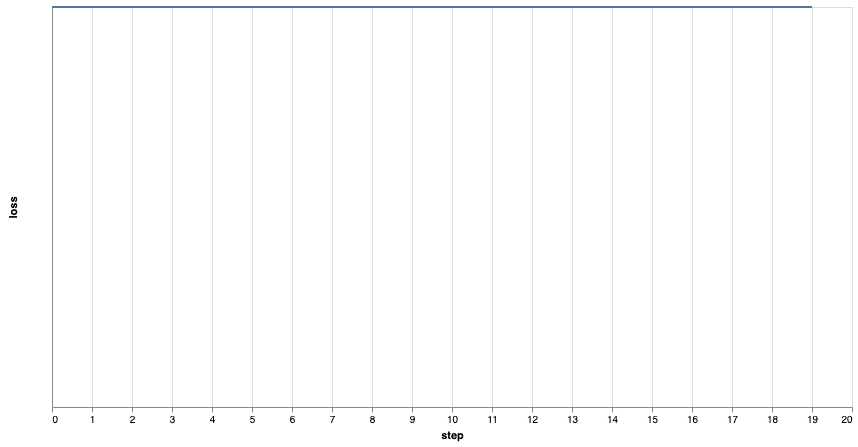

In [112]:
#!pip install altair
import altair as alt
import pandas

batch_loss = []
for i,l in enumerate(train_losses):
    batch_loss.append((i,l))

df = pandas.DataFrame(batch_loss, columns=['step', 'loss'])

alt.Chart(df).mark_line().encode(
    alt.X('step', scale=alt.Scale()),
    alt.Y('loss', scale=alt.Scale(type='log'))).properties(
        width=800,
        height=400
    )

## Analysis & Examples

## Compare N-gram LM to Neural LM

## Using FastText

## Using KenLM

In [16]:
out = vocab.FastText(language='en')

.vector_cache/wiki.en.vec:  19%|█▉        | 1.25G/6.60G [11:49<50:35, 1.76MB/s]


KeyboardInterrupt: 

In [ ]:
text_field.build_vocab(dataset, max_size=30000, vectors=out)

In [ ]:
# making a batch iterator
train_loader = data.BucketIterator(dataset=dataset, batch_size=4, sort_key=lambda x: len(x.reviewText), device=torch.device('cpu'), sort_within_batch=True, repeat=False)

In [ ]:
batch = next(iter(train_loader))
print(batch)

In [ ]:
def _vec2txt(vec):
    return [text_field.vocab.itos[t] for t in vec]

In [ ]:
print(batch.reviewText[0][0])
print(_vec2txt(batch.reviewText[0][0]))